In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([7, 6, 5, 3, 1, 9, 8, 4, 2]), tensor([ 0, 10]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn


linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[1.2824],
        [3.0366]], grad_fn=<AddmmBackward0>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[0.5365]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([-0.6328], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([-0.0964], grad_fn=<AddBackward0>)

# Batching Input

Any module in nn is written to produce outputs for a batch of multiple inputs at the
same time. Thus, assuming we need to run nn.Linear on 10 samples, we can create an
input tensor of size B × Nin, where B is the size of the batch and Nin is the number of
input features, and run it once through the model. For example:

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.0964],
        [-0.0964],
        [-0.0964],
        [-0.0964],
        [-0.0964],
        [-0.0964],
        [-0.0964],
        [-0.0964],
        [-0.0964],
        [-0.0964]], grad_fn=<AddmmBackward0>)

# Optimizing Batch

In [11]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

In [13]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

In [14]:
linear_model.parameters()

<generator object Module.parameters at 0x7f9e224b0970>

In [15]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.8973]], requires_grad=True),
 Parameter containing:
 tensor([0.0587], requires_grad=True)]

In [16]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)

        loss_val = loss_fn(t_p_val, t_c_val)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
            f" Validation loss {loss_val.item():.4f}")

In [17]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [18]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [20]:
training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 2.9804, Validation loss 3.4384
Epoch 1000, Training loss 2.9793, Validation loss 3.3448
Epoch 2000, Training loss 2.9793, Validation loss 3.3277
Epoch 3000, Training loss 2.9793, Validation loss 3.3245

Parameter containing:
tensor([[5.1576]], requires_grad=True)
Parameter containing:
tensor([-16.2433], requires_grad=True)


# Replacing Linear Model

![Simple Neural Network Model](../images/simple_nn_model.png "Simple Neural Network Model")

In [21]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

# Inspecting the Parameters

In [22]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [23]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


The name of each module in Sequential is just the ordinal with which the module appears in the arguments. Interestingly, Sequential also accepts an OrderedDict, in which we can name each module passed to Sequential:

In [24]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [25]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [26]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.2163], requires_grad=True)

In [27]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)


print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 168.4636, Validation loss 208.6387
Epoch 1000, Training loss 6.7124, Validation loss 4.9357
Epoch 2000, Training loss 4.0085, Validation loss 4.1859
Epoch 3000, Training loss 2.1244, Validation loss 1.9768
Epoch 4000, Training loss 1.8626, Validation loss 2.1245
Epoch 5000, Training loss 1.8112, Validation loss 2.4231
output tensor([[ 2.6813],
        [20.7024]], grad_fn=<AddmmBackward0>)
answer tensor([[ 0.5000],
        [21.0000]])
hidden tensor([[ 0.0037],
        [ 0.0107],
        [ 0.0434],
        [ 0.0039],
        [-0.0111],
        [-0.0112],
        [-0.0412],
        [ 0.0272]])


# Comparing with Linear Model

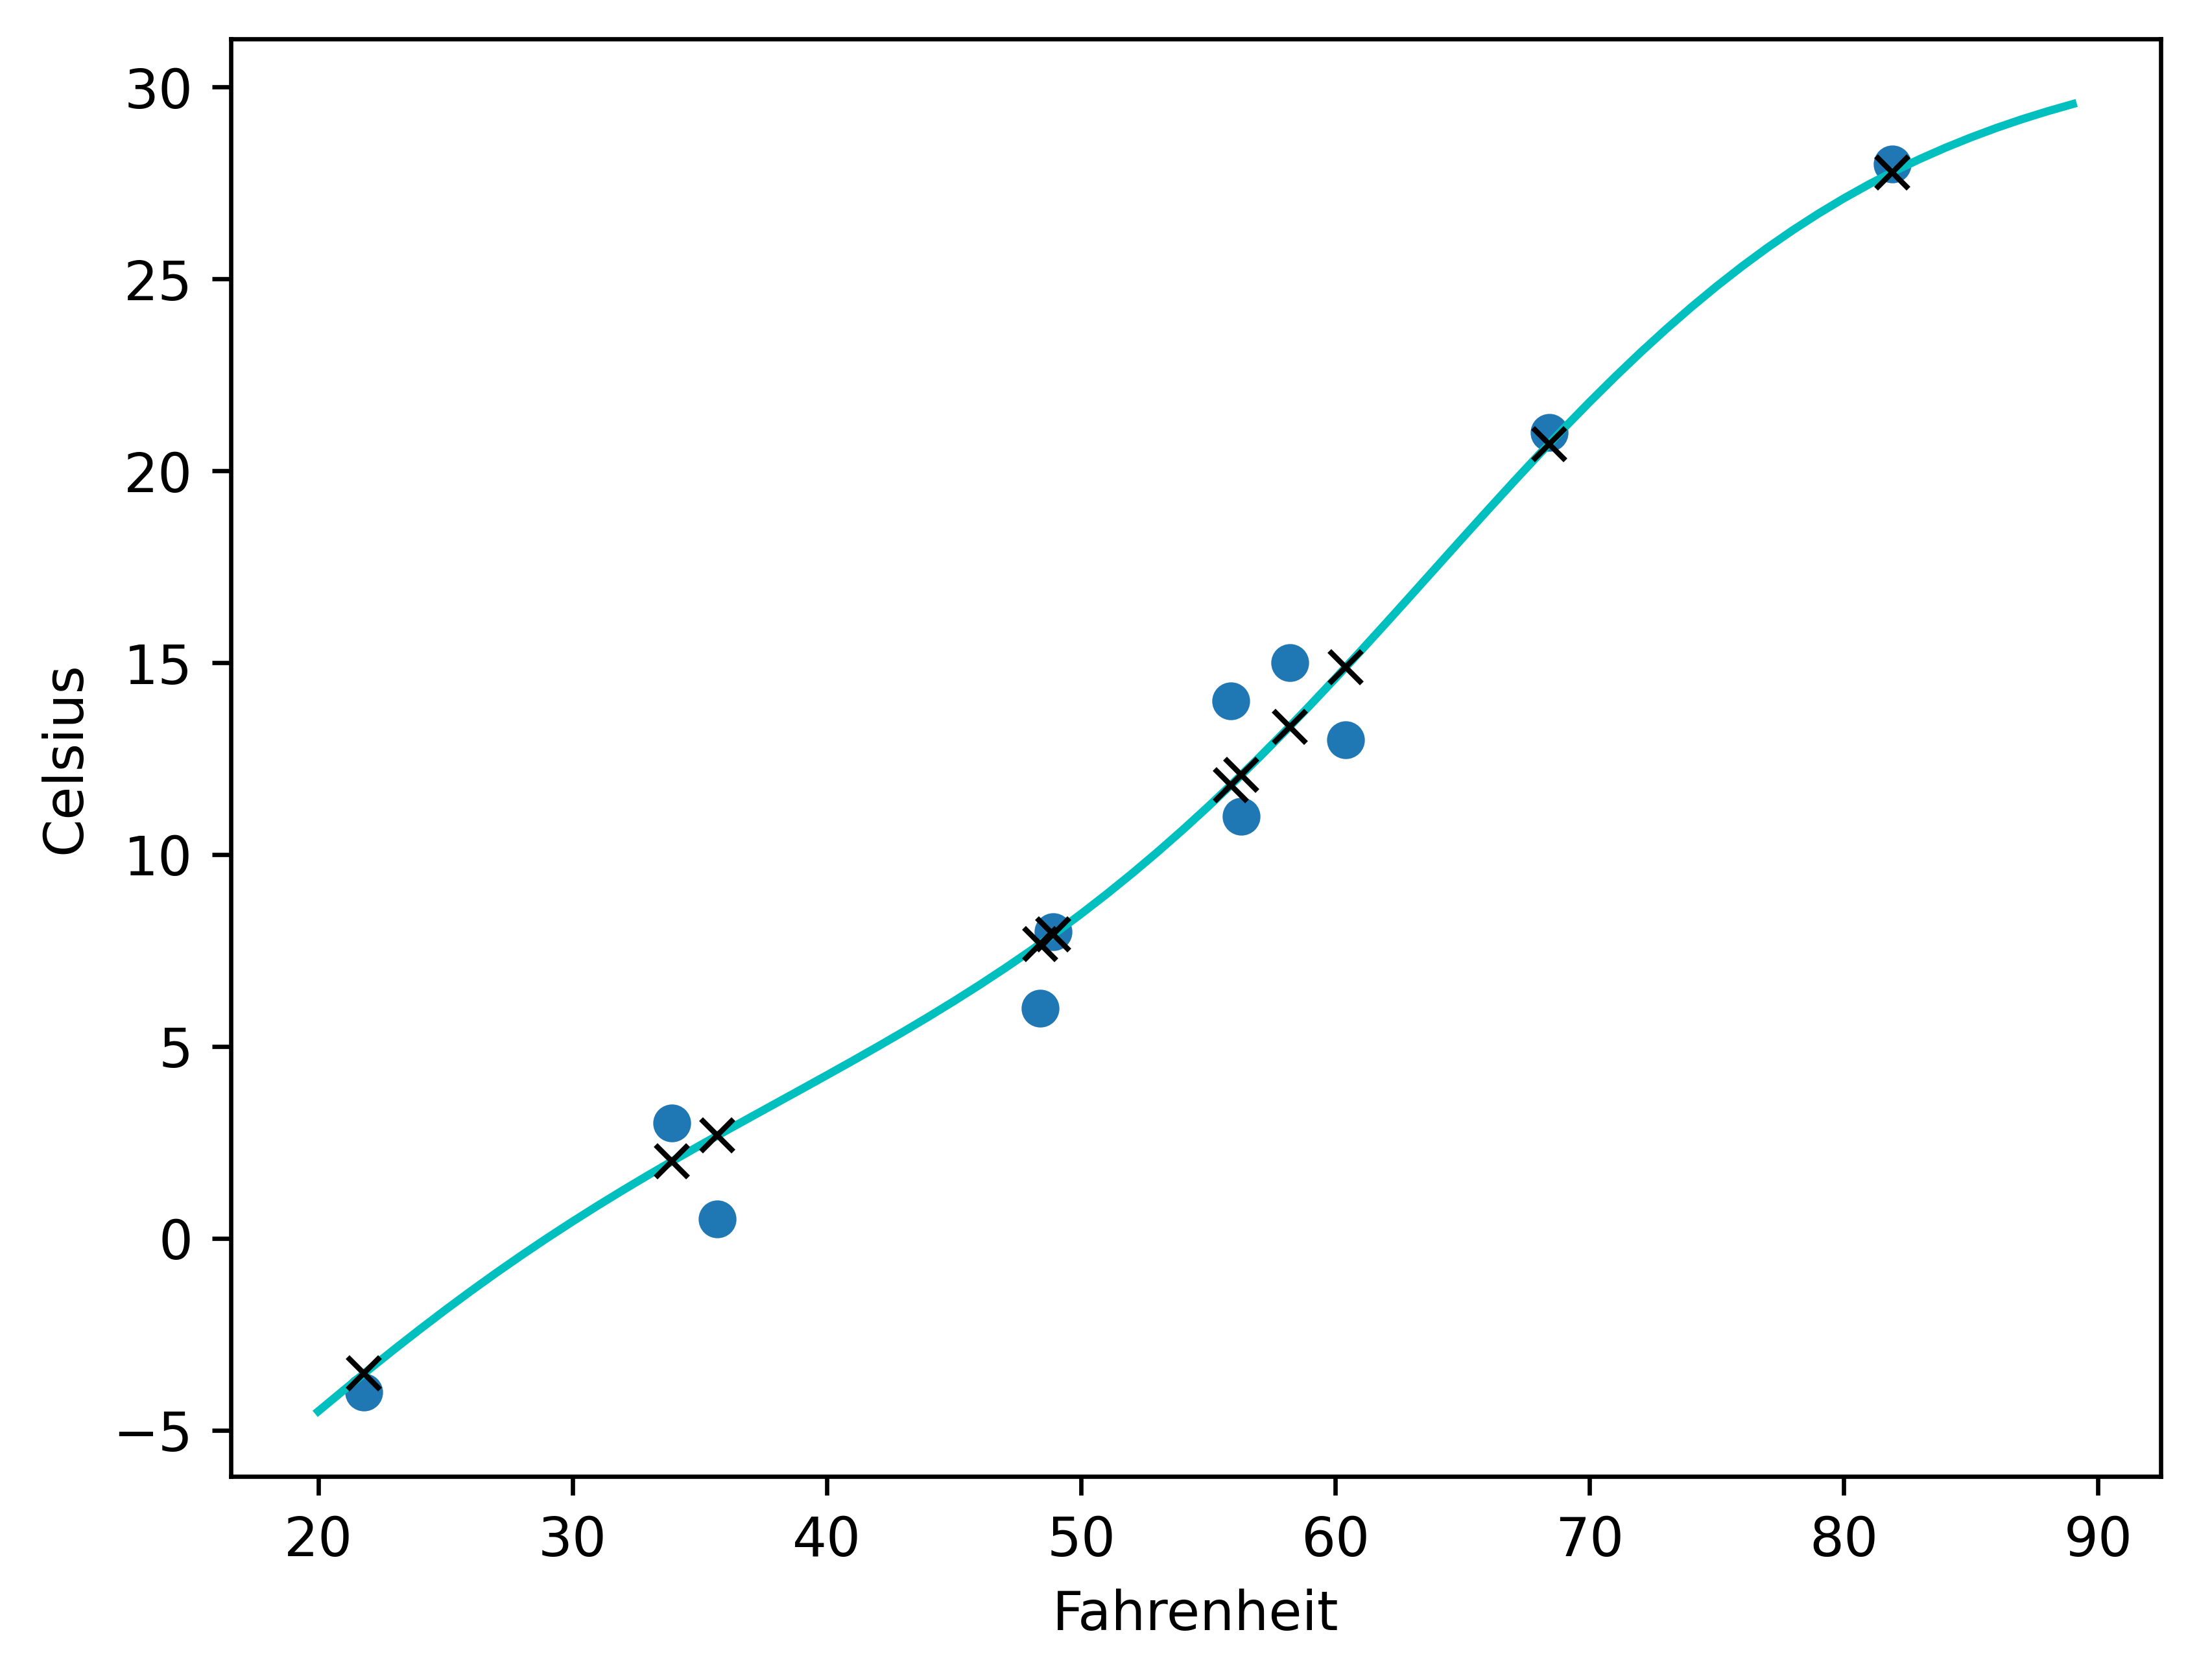

In [28]:
from matplotlib import pyplot as plt


t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')